# Решение СЛАУ и сплайн

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../numeric-core')
import numeric

# Решение СЛАУ


Реализованы следующие методы решения СЛАУ:

* Метод Гаусса &mdash; последовательное приведение к верхнетреугольному виду:

  \begin{align*}
  \left[\begin{array}{rrrr|r}
  \ddots & \vdots & \vdots & \vdots & \vdots \\
  \cdots & a_{i,j} & a_{i,j+1} & \cdots & b_{i} \\
  \cdots & a_{i+1,j} & a_{i+1,j+1} & \cdots & b_{i+1} \\
  \vdots & \vdots & \vdots & \ddots & \vdots
  \end{array}\right]\to
  \left[\begin{array}{rrrr|r}
  \ddots & \vdots & \vdots & \vdots & \vdots \\
  \cdots & a_{i,j} & a_{i,j+1} & \cdots & b_{i} \\
  \cdots & 0 & a_{i+1,j+1} - a_{i,j+1}\frac{a_{i+1,j}}{a_{i,j}} & \cdots & b_{i+1} - a_{i,j+1}\frac{a_{i+1}{j}}{a_{i,j}} \\
  \vdots & 0 & \vdots & \ddots & \vdots
  \end{array}\right]\to\ldots
  \end{align*}


* LUP-разложение &mdash; представление данной матрицы $A$ в виде $PA = LU$, где $L$ &mdash; нижнетреугольная матрица с единицами на главной диагонали, $U$ &mdash; верхнетреугольная матрица, $P$ &mdash; &laquo;матрица перестановки&raquo;; на вход подаётся квадратная матрица:
  
  (Алгротим Краута)

  \begin{align*}
  U_{i,k} &=& A_{i,k} - \sum\limits_{j=0}^{i} U_{j,k}\cdot L_{i,j} \\
  L_{i,k} &=& \left(A_{i,k} - \sum\limits_{j=0}^{k} U_{j,k}\cdot L_{i,j}\right) \Bigm/ U_{k,k}
  \end{align*}


* Метод прогонки (алгоритм Томаса) для трёхдиагональных матриц:
  
  Имеется система уравнений:

  \begin{align*}
  A_ix_{i-1} + C_ix_{i} + B_ix_{i+1} = F_i,\quad (A_1 = 0, B_n = 0)
  \end{align*}

  Тогда будем решать:

  \begin{align*}
  x_i = \alpha_{i+1}x_{i+1} + \beta_{i+1},\, \text{где}\, i=n-1,\dots,1
  \end{align*}

  Получим:

  \begin{align*}
  \begin{cases}
    \alpha_{i+1} = \frac{-B_i}{A_i\alpha_i + C_i} \\
    \beta_{i+1} = \frac{F_i - A_i\beta_i}{A_i\alpha_i + C_i}
  \end{cases}
  \end{align*}

  Решение:
  \begin{align*}
  x_i = {\alpha_{i+1}x_{i+1} + \beta_{i+1}},& \;i=n-1,\ldots,1 \\
  x_n = \frac{F_n-A_n\beta_n}{C_n+A_n\alpha_n}& 
  \end{align*}

In [3]:
matrices = [
    [[1., 2., 3.],[2.0001, 3.999, 6.], [15., 3., 6.]],
    scipy.linalg.hilbert(8),
    [[np.power(10., 6), 2.], [np.power(10., 13), 2.]]
]

In [4]:
df = pd.DataFrame([
    [np.linalg.det(matrix) for matrix in matrices],
    [np.linalg.norm(matrix) for matrix in matrices],
    [np.linalg.cond(matrix) for matrix in matrices],
], columns=['Determinant', 'Norm', 'Condition number'])

df

,Determinant,Norm,Condition number
0,0.038700,2.737050e-33,-2.000000e+13
1,18.438883,1.722143e+00,1.000000e+13
2,47773.879834,1.525758e+10,5.000001e+12


In [5]:
def run_thomas(M, b):
    A, C, B = [0.0], [], []
    for i in range(len(M)):
        for j in range(len(M[i])):
            if j == i - 1:
                A.append(M[i][j])
            elif j == i:
                C.append(M[i][j])
            elif j == i + 1:
                B.append(M[i][j])
            elif M[i][j] != 0.0:
                return None
    B.append(0.0)
    return numeric.tridiagonal_thomas(A, C, B, b)

In [6]:
def solution_norm(solver, A, b):
    x = solver(A.astype(np.float64).tolist(), b.astype(np.float64).tolist())
    if x is None: return None
    return np.linalg.norm(np.dot(A, np.array(x)) - b)


error_norms = pd.DataFrame(np.array([
    [solution_norm(numeric.gaussian_elimination, np.array(matrix), np.ones(len(matrix))) for matrix in matrices],
    [solution_norm(numeric.lu_decomposition, np.array(matrix), np.ones(len(matrix))) for matrix in matrices],
    [solution_norm(run_thomas, np.array(matrix), np.ones(len(matrix))) for matrix in matrices],
]).T, columns=['Gaussian', 'LU', 'Thomas'])

pd.concat([df, error_norms], axis=1)

,Determinant,Norm,Condition number,Gaussian,LU,Thomas
0,0.038700,2.737050e-33,-2.000000e+13,0,0,None
1,18.438883,1.722143e+00,1.000000e+13,8.91119e-12,8.91119e-12,None
2,47773.879834,1.525758e+10,5.000001e+12,0,0,0


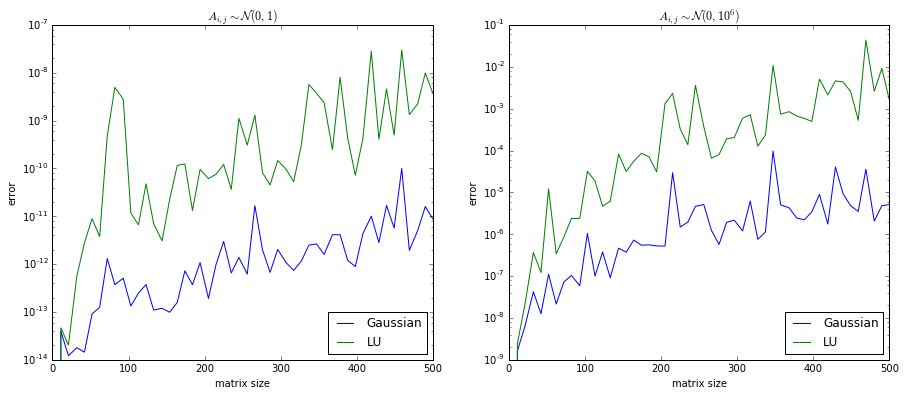

In [7]:
np.random.seed(42)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))


N = list(map(lambda x: int(np.round(x)), np.linspace(1, 500)))
M = [np.random.normal(size=(n, n)) for n in N]
b = [np.random.normal(size=n) for n in N]

assert(all([np.abs(np.linalg.det(m)) > 1e-16 for m in M]))

ax1.plot(N, [solution_norm(numeric.gaussian_elimination, elem[0], elem[1]) for elem in zip(M, b)], label='Gaussian', color='b')
ax1.plot(N, [solution_norm(numeric.lu_decomposition, elem[0], elem[1]) for elem in zip(M, b)], label='LU', color='g')
ax1.set_title(r'$A_{i,j} \sim \mathcal{N}(0, 1)$')
ax1.set_xlabel(r'matrix size')
ax1.set_ylabel(r'error')
ax1.set_yscale('log')
ax1.legend(loc=4)


M = [np.random.normal(0, 1e6, size=(n, n)) for n in N]
b = [np.random.normal(0, 1e6, size=n) for n in N]

assert(all([np.abs(np.linalg.det(m)) > 1e-16 for m in M]))

ax2.plot(N, [solution_norm(numeric.gaussian_elimination, elem[0], elem[1]) for elem in zip(M, b)], label='Gaussian', color='b')
ax2.plot(N, [solution_norm(numeric.lu_decomposition, elem[0], elem[1]) for elem in zip(M, b)], label='LU', color='g')
ax2.set_title(r'$A_{i,j} \sim \mathcal{N}(0, 10^6)$')
ax2.set_xlabel(r'matrix size')
ax2.set_ylabel(r'error')
ax2.set_yscale('log')
ax2.legend(loc=4)

Метод Гаусса даёт меньшую погрешность (в обоих методах используется выбор максимального *pivot*-элемента).

In [8]:
def tridiagonal_to_matrix(A, C, B):
    ret = np.zeros((len(C), len(C)))
    
    for i in range(len(C)):
        if i:
            ret[i][i - 1] = A[i]
        ret[i][i] = C[i]
        if i + 1 != len(C):
            ret[i][i + 1] = B[i]
            
    return ret

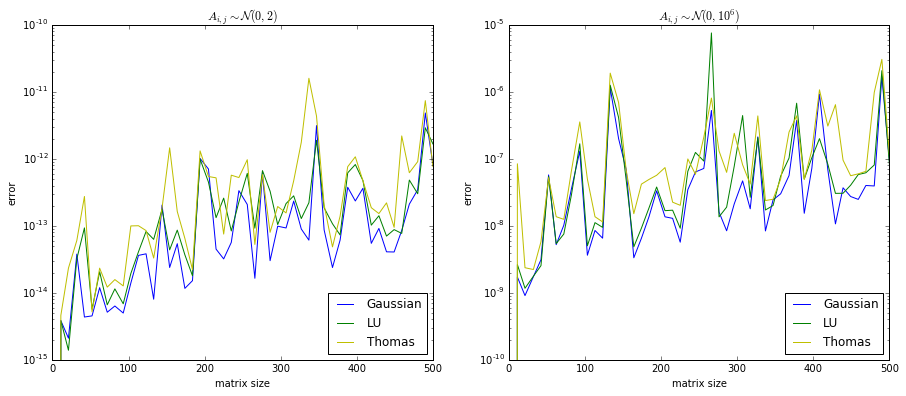

In [9]:
np.random.seed(42)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))


N = list(map(lambda x: int(np.round(x)), np.linspace(1, 500)))
z = [np.random.normal(0, 2, size=(3, n)) for n in N]
M = [tridiagonal_to_matrix(m[0], m[1], m[2]) for m in z]
b = [np.random.normal(0, 2, size=n) for n in N]

assert(all([np.abs(np.linalg.det(m)) > 1e-16 for m in M]))

ax1.plot(N, [solution_norm(numeric.gaussian_elimination, elem[0], elem[1]) for elem in zip(M, b)], label='Gaussian', color='b')
ax1.plot(N, [solution_norm(numeric.lu_decomposition, elem[0], elem[1]) for elem in zip(M, b)], label='LU', color='g')
ax1.plot(N, [solution_norm(run_thomas, elem[0], elem[1]) for elem in zip(M, b)], label='Thomas', color='y')
ax1.set_title(r'$A_{i,j} \sim \mathcal{N}(0, 2)$')
ax1.set_xlabel(r'matrix size')
ax1.set_ylabel(r'error')
ax1.set_yscale('log')
ax1.legend(loc=4)


z = [np.random.normal(0, 1e6, size=(3, n)) for n in N]
M = [tridiagonal_to_matrix(m[0], m[1], m[2]) for m in z]
b = [np.random.normal(0, 1e6, size=n) for n in N]

assert(all([np.abs(np.linalg.det(m)) > 1e-16 for m in M]))

ax2.plot(N, [solution_norm(numeric.gaussian_elimination, elem[0], elem[1]) for elem in zip(M, b)], label='Gaussian', color='b')
ax2.plot(N, [solution_norm(numeric.lu_decomposition, elem[0], elem[1]) for elem in zip(M, b)], label='LU', color='g')
ax2.plot(N, [solution_norm(run_thomas, elem[0], elem[1]) for elem in zip(M, b)], label='Thomas', color='y')
ax2.set_title(r'$A_{i,j} \sim \mathcal{N}(0, 10^6)$')
ax2.set_xlabel(r'matrix size')
ax2.set_ylabel(r'error')
ax2.set_yscale('log')
ax2.legend(loc=4)

На разреженной матрице погрешности методов примерно одинаковы, лучший &mdash; метод Гаусса.

# Кубический сплайн дефекта 1


Кубическим сплайном дефекта 1 называется функция $S(x)$, которая:
* на каждом отрезке $[x_{i-1},x_{i}]$ является многочленом степени не выше третьей;
* имеет непрерывные первую и вторую производные на всём отрезке $[x_1,x_n]$;
* в точках $x_{i}$ выполняется равенство $S(x_{i})=f(x_{i})$

Дополнительное условие для единственности: $S''(x_1)=0, S''(x_n)=0$.

На каждом отрезке $[x_{i-1},x_{i}]$ зададим функцию как многочлен третьей степени:

\begin{align*}
S_{i}(x)=a_{i}+b_{i}(x-x_{i})+{\frac{c_{i}}{2}}(x-x_{i})^{2}+{\frac{d_{i}}{6}}(x-x_{i})^{3}
\end{align*}

Обозначим:
\begin{align*}
h_{i}=x_{i}-x_{i-1}, f_{i}=f(x_{i})
\end{align*}

Отсюда получаем формулы для вычисления коэффициентов сплайна:

\begin{align*}
a_{i} &=& f\left(x_{i}\right) \\
h_{i}c_{i-1}+2\left(h_{i}+h_{i+1}\right)c_{i}+h_{i+1}c_{i+1} &=& 6\left(\frac{f_{i+1}-f_{i}}{h_{i+1}}-\frac{f_{i}-f_{i-1}}{h_{i}}\right) \\
d_{i} &=& \frac{c_{i}-c_{i-1}}{h_{i}} \\
b_{i} &=& \frac{f_{i}-f_{i-1}}{h_{i}}+\frac{h_{i}\left(2c_{i}+c_{i-1}\right)}{6}
\end{align*}

Вычисление $c$ производится с помощью метода прогонки для трёхдиагональной матрицы.

In [10]:
def run_spline(func, a, b, ylim=None, N1=8, N2=100):
    N = [N1, N2]
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15, 6), sharex=True, sharey=True)
    
    for ax, n in zip(axs, N):
        tx, ty = numeric.tabulate_linspace(func, a, b, n)
        x, y = numeric.tabulate_spline((tx, ty), a, b, 10000)
        
        ax.plot(tx, np.vectorize(func)(tx), 'o', color='blue')
        ax.plot(x, np.vectorize(func)(x), color='blue')
        ax.plot(x, y, color='red')
        ax.set_title(r'$grid={}$'.format(n))
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$f(x)$')
        
        if ylim:
            ax.set_ylim(ylim)
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True)
    for ax, n in zip(axs, N):
        tx, ty = numeric.tabulate_linspace(func, a, b, n)
        x, y = numeric.tabulate_spline((tx, ty), a, b, 10000)
        max_diff = np.abs(np.vectorize(func)(x) - y).max()
        
        ax.plot(x, np.abs(np.vectorize(func)(x) - y))
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$|S(x) - f(x)|$')
        ax.set_yscale('log')
        ax.set_ylim(0, 2)

## Пример 1


\begin{align*}
f(x) = \sin(10x)
\end{align*}

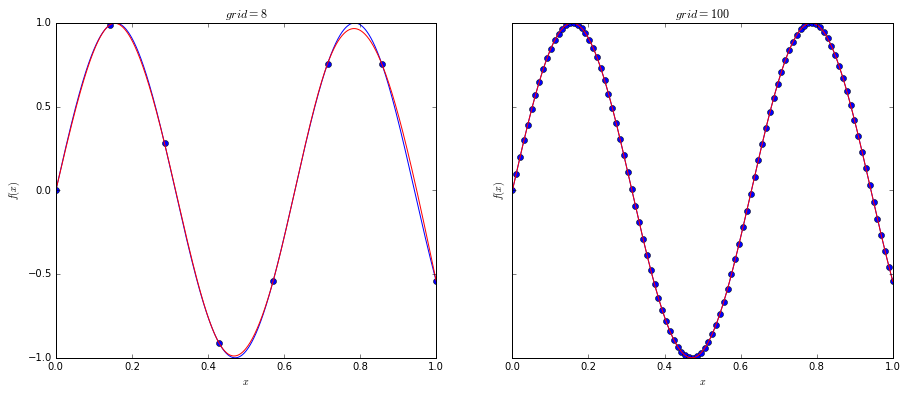

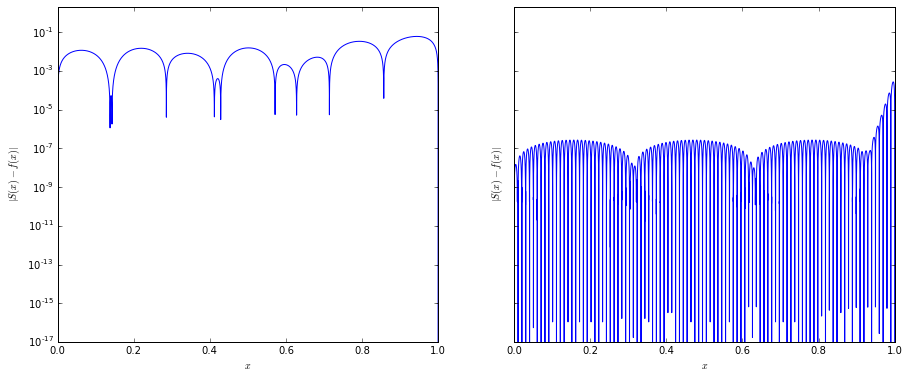

In [11]:
run_spline(lambda x: np.sin(10 * x), 0, 1)

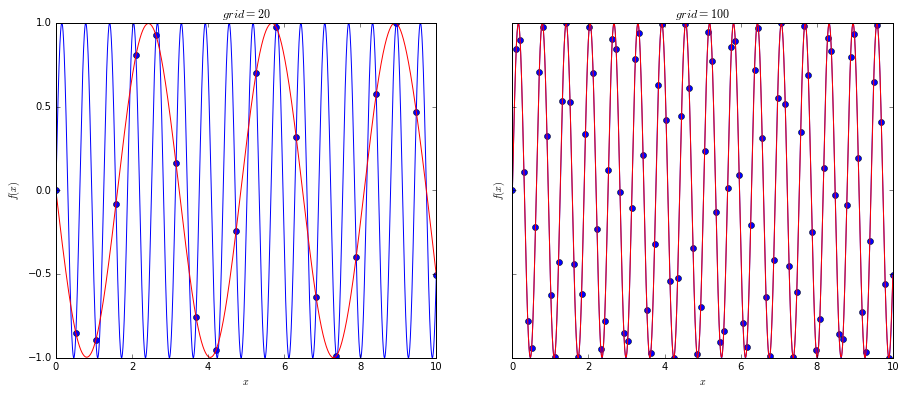

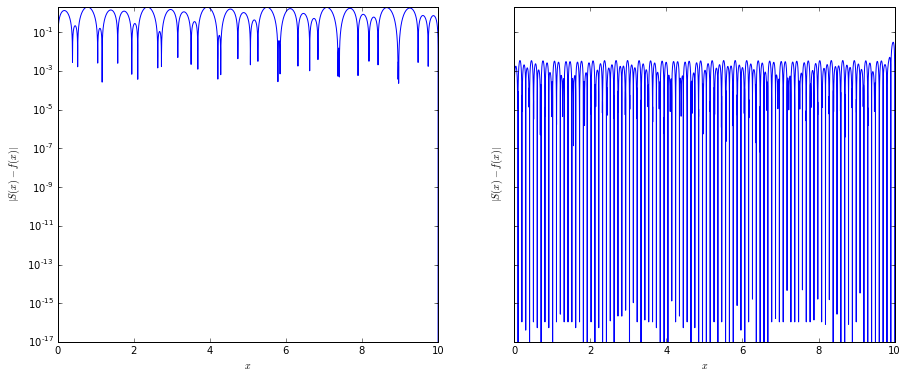

In [12]:
run_spline(lambda x: np.sin(10 * x), 0, 10, ylim=(-1, 1), N1=20)

## Пример 2


Многочлен.

In [13]:
class Polynom:
    def __init__(self, c):
        self.c = c
    
    def __call__(self, x):
        ret = 0.0
        for idx, c in enumerate(self.c):
            ret += np.power(x, idx) * c
        return ret

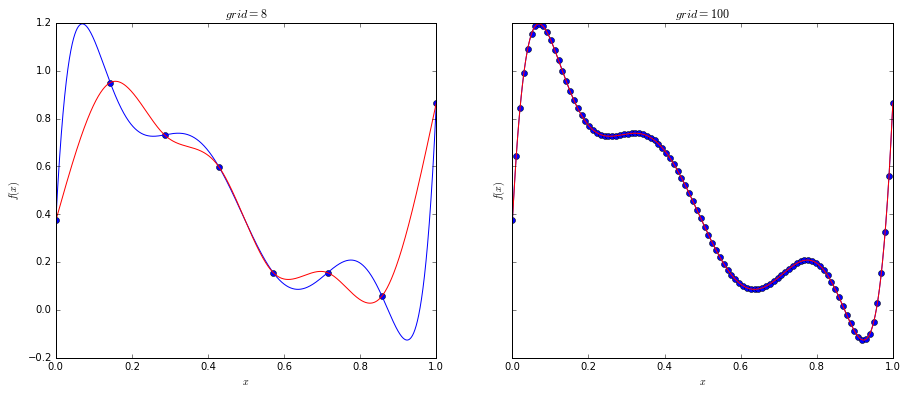

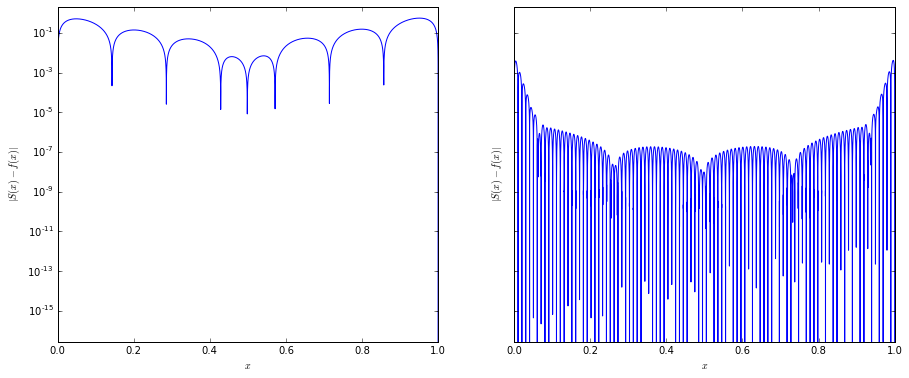

In [14]:
np.random.seed(42)

x = np.linspace(0, 1, 8)
y = [np.random.random() for _ in x]

run_spline(Polynom(np.polyfit(x, y, len(x) - 1)[::-1]), 0, 1)

## Пример 3


\begin{align*}
f_N(x) = \frac{\left\lfloor Nx \right\rfloor}{N}
\end{align*}

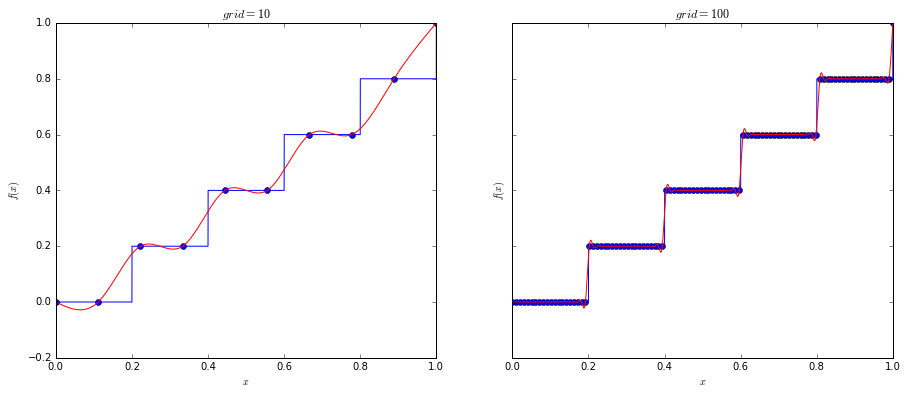

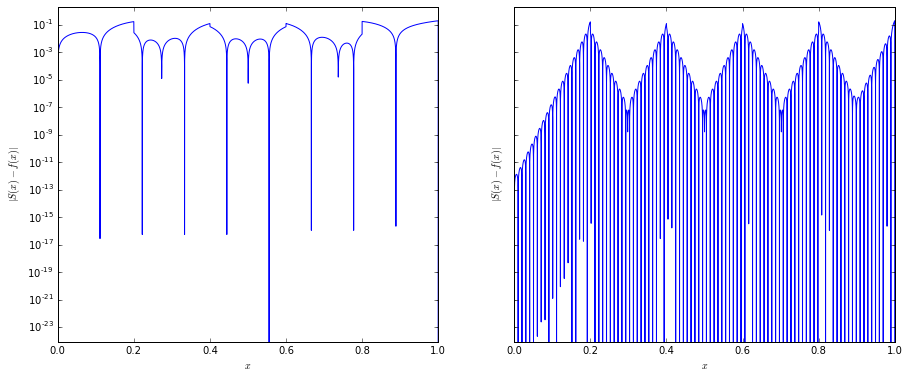

In [15]:
N = 5
func = lambda x: np.floor(N * x) / N

run_spline(func, 0, 1, N1=10)

Более плотная лесенка:

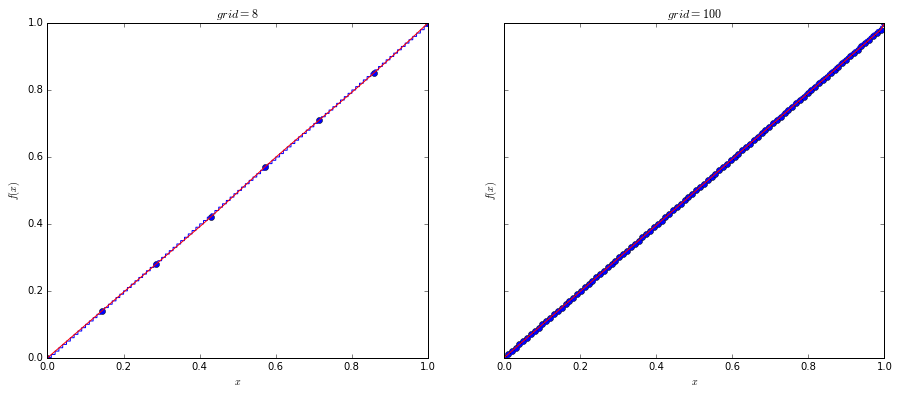

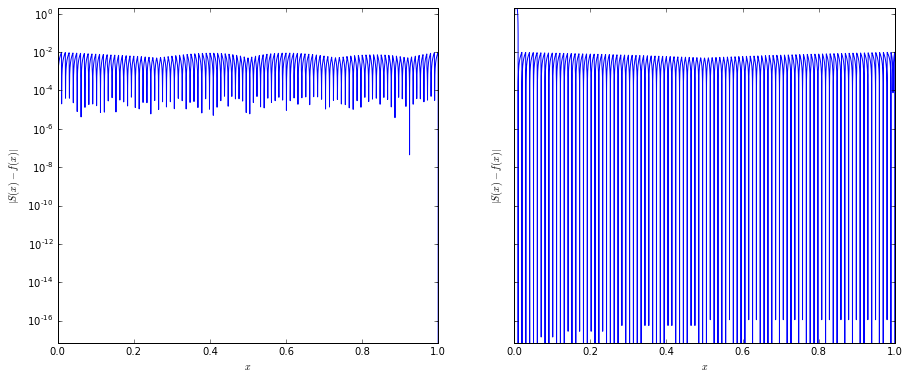

In [16]:
N = 100
func = lambda x: np.floor(N * x) / N

run_spline(func, 0, 1)

## Пример 4


\begin{align*}
f(x) = x \cdot sin(1\,000x)
\end{align*}

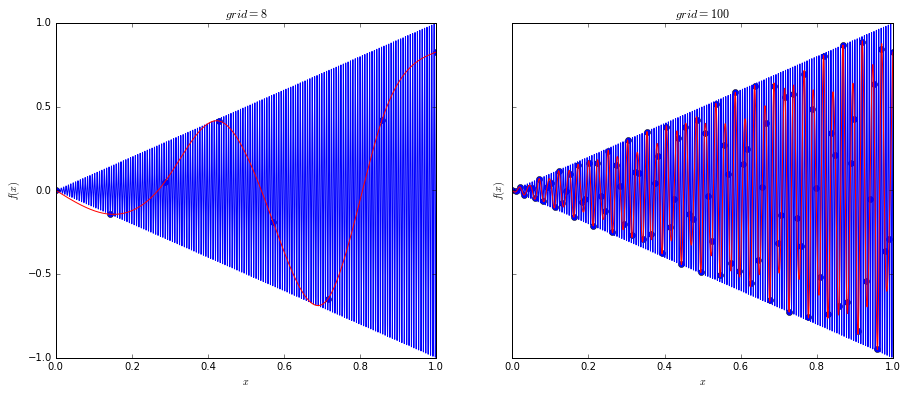

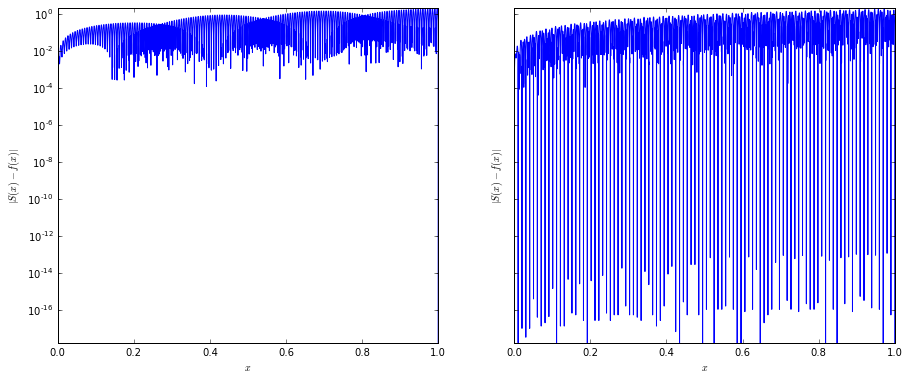

In [17]:
func = lambda x: x * np.sin(1e3 * x)

run_spline(func, 0, 1)

## Пример 5


\begin{align*}
f(x) = e^x \cdot \sin(100\,000 x)
\end{align*}

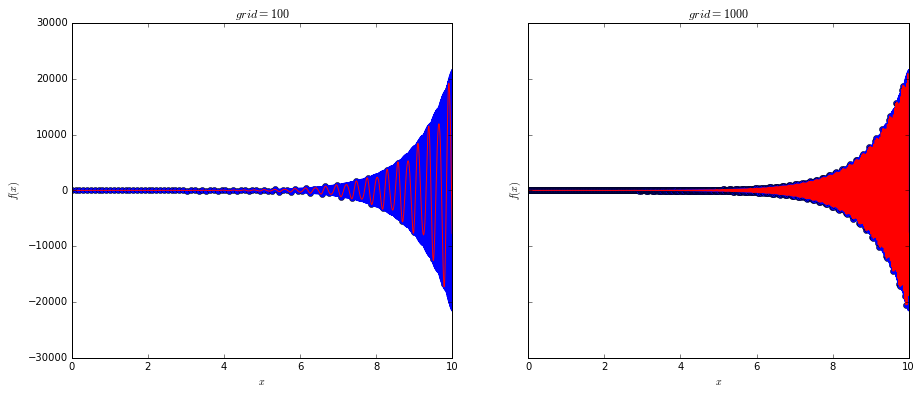

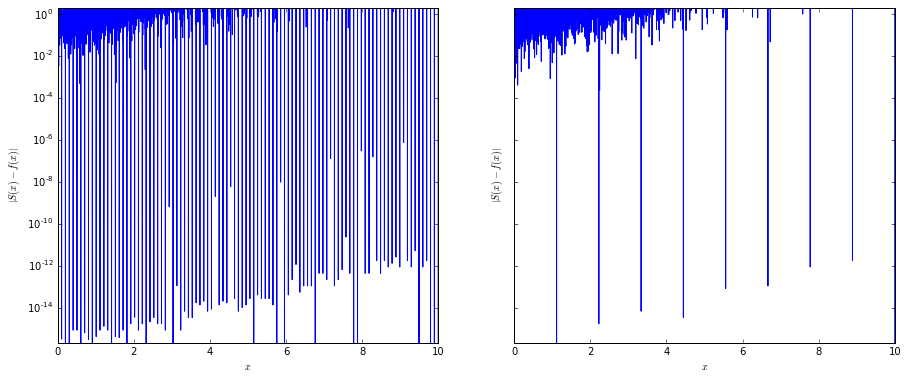

In [18]:
func = lambda x: np.power(np.e, x) * np.sin(1e5 * x)

run_spline(func, 0, 10, N1=100, N2=1000)

#### Как и следовало ожидать, наосциллирующих функциях алгоритм даёт большую погрешность. Разрывные функции приближаются достаточно неплохо.